In [1]:
import warnings
warnings.filterwarnings("ignore")

%pylab inline
%load_ext autoreload
%autoreload 2
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# In Jupyter you have to stop the current context first
# sc.stop()

# Create new config
conf = SparkConf().set("spark.driver.maxResultSize", "20g")

sc = SparkContext(appName="PythonKMeans", sparkHome="/usr/local/spark", conf=conf)    
sqlContext = SQLContext(sc)


In [9]:
from model.kmeans_trainer import KMeansTrainer
from pyspark.ml.clustering import KMeans, KMeansModel

# KMeans - Content Based Filtering

## Silhouette Analysis

We run a Silhouette analysis to decide how many clusters to have

In [4]:
train = KMeansTrainer.make_features(user_master)

root
 |-- features: vector (nullable = true)
 |-- feature1: string (nullable = true)
 |-- feature2: string (nullable = true)
 |-- feature3: string (nullable = true)
 |-- feature4: string (nullable = true)
 |-- feature5: string (nullable = true)
 |-- feature6: string (nullable = true)
 |-- user_id: string (nullable = true)



### 2 to 100 clusters

In [21]:
SILS = []
for k in [2+ i for i in range(10,100) ]:
  print(k)
  kmeans = KMeansTrainer(k)
  SILS.append((k,kmeans.fit(train, silhouette_score=True)))

12
silhouette score: 0.2236
13
silhouette score: 0.2320
14
silhouette score: 0.1993
15
silhouette score: 0.2240
16
silhouette score: 0.2519
17
silhouette score: 0.2575
18
silhouette score: 0.2436
19
silhouette score: 0.2492
20
silhouette score: 0.2527
21
silhouette score: 0.2402
22
silhouette score: 0.2561
23
silhouette score: 0.2642
24
silhouette score: 0.2454
25
silhouette score: 0.2507
26
silhouette score: 0.2430
27
silhouette score: 0.2559
28
silhouette score: 0.2517
29
silhouette score: 0.2715
30
silhouette score: 0.2724
31
silhouette score: 0.2677
32
silhouette score: 0.2687
33
silhouette score: 0.2731
34
silhouette score: 0.2676
35
silhouette score: 0.2486
36
silhouette score: 0.2500
37
silhouette score: 0.2764
38
silhouette score: 0.2415
39
silhouette score: 0.2907
40
silhouette score: 0.2460
41
silhouette score: 0.2365
42
silhouette score: 0.2582
43
silhouette score: 0.2325
44
silhouette score: 0.2334
45
silhouette score: 0.2537
46
silhouette score: 0.2629
47
silhouette score:

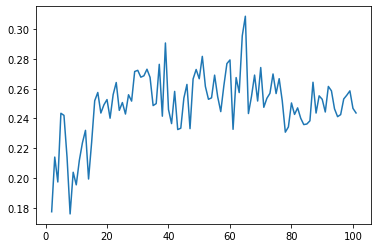

In [22]:
sils = pd.DataFrame(SILS, columns=["clusters", "silhouette"])
plt.plot(sils.clusters, sils.silhouette)

### 200 ~ 1000

In [132]:
#SILS = []
for k in [200+ i*100 for i in range(10) ]:
  print(k)
  kmeans = KMeansTrainer(k)
  SILS.append((k,kmeans.fit(train, silhouette_score=True)))

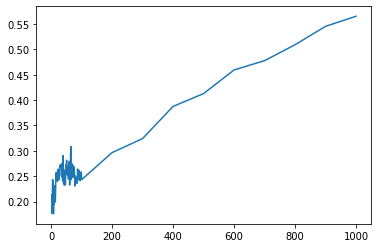

In [24]:
sils = pd.DataFrame(SILS, columns=["clusters", "silhouette"])
plt.plot(sils.clusters, sils.silhouette)

### 10,000 and 100,000 Clusters

In [28]:
pd.DataFrame([(100, 0.2468),
 (200, 0.2966),
 (300, 0.3242),
 (400, 0.3876),
 (500, 0.4128),
 (600, 0.4594),
 (700, 0.4777),
 (800, 0.5091),
 (900, 0.5453),
 ("1,000", 0.5652),
 ("2,000", 0.7375954035428014),
 ("3,000", 0.8273978500122793),
 ("4,000", 0.8893246115465561),
 ("10,000", 0.9826784149512843),
 ("100,000", 0.9971577543822016)], columns=["K", "silhouete score"])

,K,silhouete score
0,100,0.246800
1,200,0.296600
2,300,0.324200
3,400,0.387600
4,500,0.412800
5,600,0.459400
6,700,0.477700
7,800,0.509100
8,900,0.545300
9,"1,000",0.565200


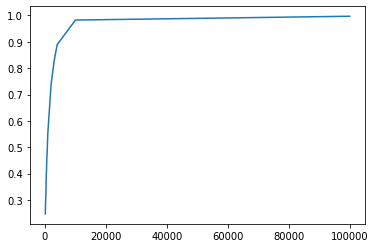

In [17]:
sils = pd.DataFrame(s, columns=["clusters", "silhouette"])
plt.plot(sils.clusters, sils.silhouette)

## Running the Model

In [ ]:
target_users = sqlContext.read.csv("data/target_users.tsv",sep="\t", header=True)
user_master  = sqlContext.read.csv("data/user_master.tsv",sep="\t", header=True) 

In [7]:
train = KMeansTrainer.make_features(user_master)
frequencies = sqlContext.read.csv("data/train_frequencies.tsv",sep="\t", header=True)

In [15]:
# Uncomment this cell if you want to fit the cluster yourself

#kmeans = KMeans().setK(5000).setSeed(42)
#model = kmeans.fit(train)

In [16]:
# If you did not fit the cluster you can load a pre-fitted model in this cell

from pyspark.ml.clustering import KMeansModel
model = KMeansModel.load("models/kmeans_5000.pkl")

In [18]:
import pyspark.sql.functions as sf
from pyspark.sql.functions import desc

# In order to make a cluster based recommendation 
# We need to rank the items per cluster and by 
# the number of times it appeared in the 'frequency' columns

all_clusters = model.transform(train)
cluster_hist = frequencies.join(all_clusters, ["user_id"], how="inner")
cluster_hist = cluster_hist.groupBy(["prediction","item_id"]).agg(sf.sum("frequency").alias("frequency"))
cluster_hist = cluster_hist.sort(desc("frequency"))

In [19]:
import pyspark.sql.functions as f
# In this cell 
# Find the cluster of each target user
# Then, group the cluster recommendation 
# by user_id to create a recommendation_list


# Limit the prediction to the target_users
pred = model.transform(train.join(target_users, ["user_id"], how="inner"))

userRecs = (cluster_hist.join(pred, ["prediction"], how="inner")
 .groupby("user_id")
 .agg(f.collect_list("item_id").alias("recommended_items") )
)

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# This Column Parsers the recommended_items list 
# and writes as a string so our 'evaluate' function
# can read it. 

# The trick part is creating a udf function 
# So pySpark can pickle it and share with all
# executors. 

# The last line saves the recommendation list to a file 
# read to be read by the 'evaluate' function

def array_to_string(my_list):
    return str(','.join([str(elem) for elem in my_list[:72]]))

array_to_string_udf = udf(array_to_string, StringType())
to_csv = userRecs.withColumn('recommended_items', 
                             array_to_string_udf(userRecs["recommended_items"]))
to_csv.write.csv(f"data/spark_kmeans_target_users.tsv", sep="\t", mode="overwrite")

In [21]:
# We Evaluate the recommended items under nDCG@72 metrics 
# Using our custom evaluate function in the `utils` folder

from utils.evaluate import evaluate
filepath = "data/spark_kmeans_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

248,000 / 248,487 (99.80)%
Stoping Writer
Entropy: 14.30014044466658
nDCG avg:0.001138


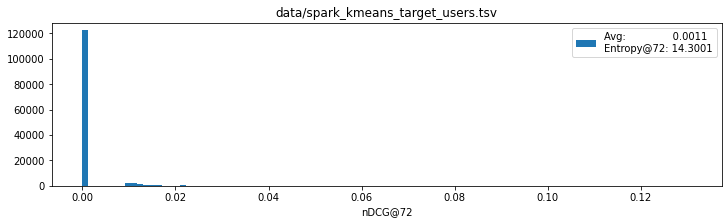

In [22]:
# k = 5000
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

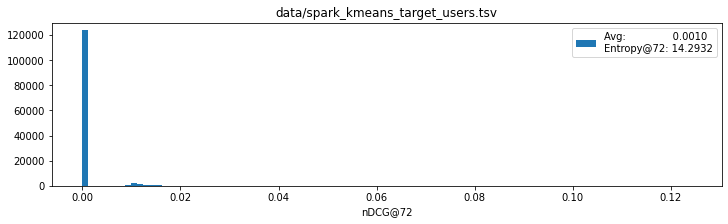

In [116]:
# This plot is from the same cells above with the difference the model has 3000 clusters instead of 5000
# k = 3000
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()